In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_names = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        mask_path = os.path.join(self.mask_dir, self.img_names[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask.long()

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Directories
img_dir = '/content/drive/MyDrive/images'
mask_dir = '/content/drive/MyDrive/masks'

# Dataset and DataLoader
dataset = CustomDataset(img_dir, mask_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

In [8]:
# U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            self.double_conv(in_channels, 64),
            nn.MaxPool2d(2),
            self.double_conv(64, 128),
            nn.MaxPool2d(2),
            self.double_conv(128, 256),
            nn.MaxPool2d(2),
            self.double_conv(256, 512),
            nn.MaxPool2d(2),
            self.double_conv(512, 1024),
        )

        self.decoder = nn.Sequential(
            self.up_conv(1024, 512),
            self.double_conv(1024, 512),
            self.up_conv(512, 256),
            self.double_conv(512, 256),
            self.up_conv(256, 128),
            self.double_conv(256, 128),
            self.up_conv(128, 64),
            self.double_conv(128, 64),
        )

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder[0](x)
        enc2 = self.encoder[2](self.encoder[1](enc1))
        enc3 = self.encoder[4](self.encoder[3](enc2))
        enc4 = self.encoder[6](self.encoder[5](enc3))
        enc5 = self.encoder[8](self.encoder[7](enc4))

        dec4 = self.decoder[0](enc5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder[1](dec4)
        dec3 = self.decoder[2](dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder[3](dec3)
        dec2 = self.decoder[4](dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder[5](dec2)
        dec1 = self.decoder[6](dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder[7](dec1)

        return self.final_conv(dec1)
num_classes = 3
model = UNet(in_channels=3, out_channels= num_classes)

Epoch [1/10], Train Loss: 1.0744
Epoch [2/10], Train Loss: 1.0054
Epoch [3/10], Train Loss: 0.4764
Epoch [4/10], Train Loss: 0.0763
Epoch [5/10], Train Loss: 0.0172
Epoch [6/10], Train Loss: 0.0066
Epoch [7/10], Train Loss: 0.0067
Epoch [8/10], Train Loss: 0.0042
Epoch [9/10], Train Loss: 0.0041
Epoch [10/10], Train Loss: 0.0038


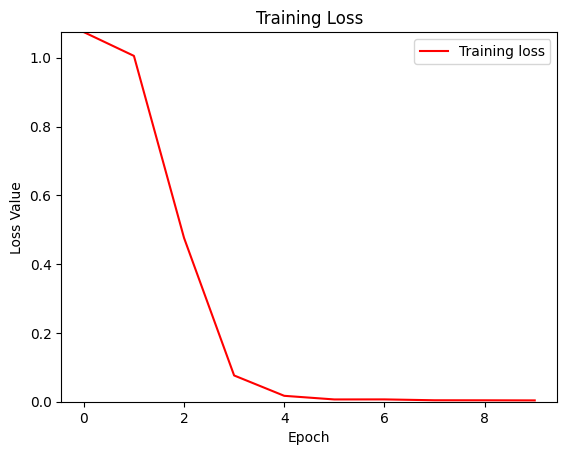

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for images, masks in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.squeeze(1))  # Remove channel dimension from masks
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}')

    return train_losses

train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs)

# Plotting training loss
plt.figure()
plt.plot(range(len(train_losses)), train_losses, 'r', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, max(train_losses)])
plt.legend()
plt.show()

In [18]:
def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, dim=1)
    return pred_mask

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(display_list[i].cpu().numpy().transpose(1, 2, 0))
        else:
            plt.imshow(display_list[i].cpu().numpy().squeeze())  # Squeeze to (H, W)
        plt.axis('off')
    plt.show()

def show_predictions(dataset=None, model=None, num=2):
    dataiter = iter(dataset)
    for _ in range(num):
        images, masks = next(dataiter)
        outputs = model(images)
        preds = create_mask(outputs)
        display([images[0], masks[0], preds[0]])

show_predictions(dataset=train_loader, model=model, num=2)